# Preview
---
#### 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
- KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.

#### 2. RetinaNet 학습이 정상적으로 진행되어 Object Detection 결과의 시각화까지 진행되었다.
- 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.

#### 3. 자율주행 Object Detection 테스트시스템 적용 결과 만족스러운 정확도 성능을 달성하였다.
- 테스트 수행 결과 90%이상의 정확도를 보였다.

# 자율주행 보조 시스템 만들기

## 1. KITTI데이터셋 분석
---
- [KITTI](http://www.cvlibs.net/datasets/kitti/) 데이터셋은 자율주행을 위한 데이터셋이다.
- 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공한다
    - 다음은 제공하는 라벨 정보이다
    ![image](https://user-images.githubusercontent.com/48716219/97407066-7dd8ed00-193d-11eb-9518-0d69ff24892a.png)
- 여기서는 ```tensorflow_dataset```을 활용해서 데이터를 가져온다.
    - 처음 설치할 경우 11GB가 넘어가는 대용량의 데이터셋이기 때문에 매우 오래걸린다.

### 1) 라이브러리 Import

In [102]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [103]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

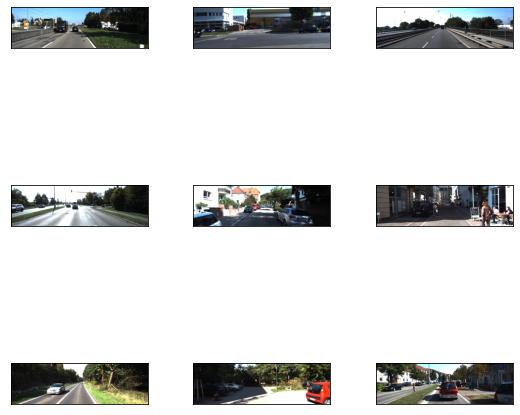

In [108]:
fig = tfds.show_examples(ds_train, ds_info)

In [105]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

### 2) 데이터 확인해보기
- 확인을 해보면 TakeDataset에 담긴 내용들은 xml 혹은 Json({key : value})과 같은 형태로 정보들이 담겨 있는 것을 확인할 수 있다.
- 실제로 tensorflow_dataset을 통해서 받는 것이 아닌 직접 받아서 확인해보면 각 이미지에 대한  annotation이 담겨있는 xml파일을 확인할 수 있다.
    - xml파싱에 대한 내용은 다음 블로그에서 사용했었다. ([링크](https://blog.naver.com/ab415/222028110136))
    - [AI Hub에서 제공받은 인도 보행 영상](https://aihub.or.kr/aidata/136)의 annotation을 KITTI 데이터셋의 xml 형식으로 바꿨었다.
- 여기서 사용할 annotation정보는 이미지의 바운딩 박스 정보를 담은 bbox를 사용할 것이다.
    - ```bbox```에는 4개의 값이 있고 각각 ```left```, ```top```, ```right```, ```bottom``` 의 pixel 정보이다.

In [116]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.59, -1.49,  2.52,  2.24, -1.61], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.41186666, 0.44596618, 0.50765336, 0.4818599 ],
       [0.43792   , 0.4044042 , 0.50936   , 0.43278584],
       [0.40386668, 0.67444444, 0.49322668, 0.7416586 ],
       [0.39712   , 0.7694283 , 0.49381334, 0.8429469 ],
       [0.47074667, 0.45102254, 0.55776   , 0.47136876]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.26, 1.6 , 3.56],
       [1.37, 1.63, 3.57],
       [1.38, 1.35, 3.3 ],
       [1.59, 1.73, 4.02],
       [2.26, 1.64, 5.2 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.39,  1.73, 27.81],
       [-4.95,  2.  , 39.72],
       [11.95,  2.18, 32.11],
       [18.79,  2.44, 34.7 ],
       [-2.79,  1.81, 52.88]], dtype=float32)>, 'occluded': <tf.Ten

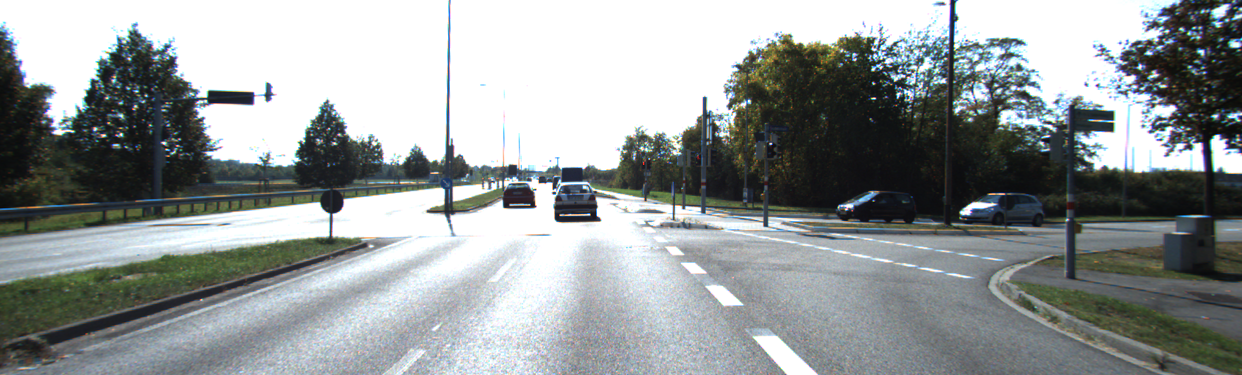

In [117]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

### 3) 이미지에 Bounding Box 시각화

width : 1242, height : 375

이미지 내에 있는 bounding box : 5개
[[ 553.89     220.55     598.47     184.62999]
 [ 502.27002  210.78     537.52     183.98999]
 [ 837.66     223.55     921.14     190.04   ]
 [ 955.62994  226.08    1046.9401   189.81999]
 [ 560.17     198.47     585.44     165.84   ]]
[553.89    220.55    598.47    184.62999]
[502.27002 210.78    537.52    183.98999]
[837.66 223.55 921.14 190.04]
[ 955.62994  226.08    1046.9401   189.81999]
[560.17 198.47 585.44 165.84]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F0E730714D0>


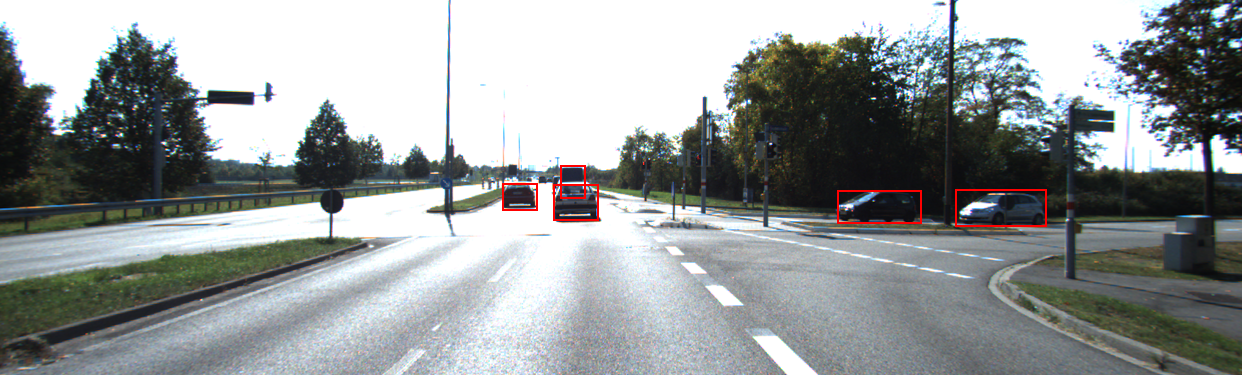

In [122]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(f'width : {width}, height : {height}')
    print(f'\n이미지 내에 있는 bounding box : {object_bbox.shape[0]}개')
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 2. 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받는다.
- 정지조건에 맞는 경우 "stop" 아닌 경우 "go"를 반환한다.
- 조건은 다음과 같다.
    1. 사람이 한 명 이상 있는 경우
    2. 차량의 크기(width or height)가 300px이상인 경우

In [1]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join(os.getenv("HOME"), 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

1 Physical GPUs, 1 Logical GPUs


In [98]:
# img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
# model, img_path="./test_set/go_1.png", visualize=True):
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }
    
    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
            
            if b[2]-b[0] >= 300 or b[3]-b[1] >= 300 or label == 1 :
                result = 'Stop'
            else:
                result = 'Go'

            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()
    
        return result

[  0.      200.52882 312.55774 368.74796]
[  0 200 312 368]
[759.996   162.64774 875.9604  208.86353]


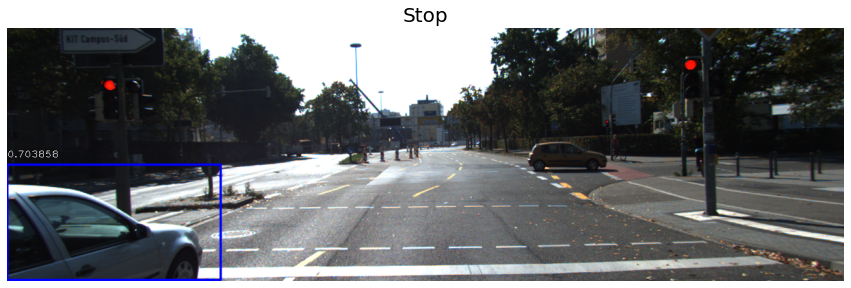

Stop


In [99]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
print(self_drive_assist(model=model,img_path=img_path))

## 3. 자율주행 시스템 평가하기
- ```test_system()```을 통해서 위에서 만든 함수를 평가해본다.
- 10장에 대해 go와 stop을 맞게 반환하는지 확인하고 100점 만점으로 평가한다.

In [100]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

/home/aiffel0042/aiffel/object_detection/test_set/stop_1.png
[773.0301  156.06113 845.1638  317.11307]
[773 156 845 317]
[735.08954 158.46077 871.2406  325.49802]


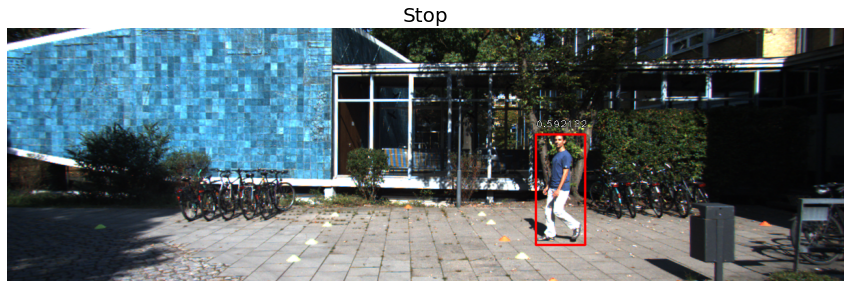

/home/aiffel0042/aiffel/object_detection/test_set/stop_2.png
[415.91016 160.07544 495.2462  335.0483 ]
[415 160 495 335]
[411.4016  160.45378 497.26495 329.03122]


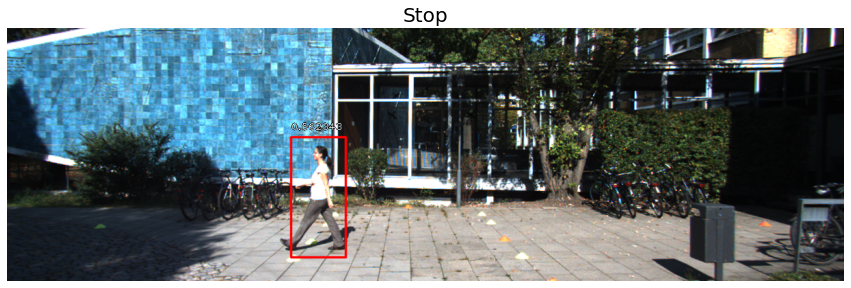

/home/aiffel0042/aiffel/object_detection/test_set/stop_3.png
[  0.      200.52882 312.55774 368.74796]
[  0 200 312 368]
[759.996   162.64774 875.9604  208.86353]


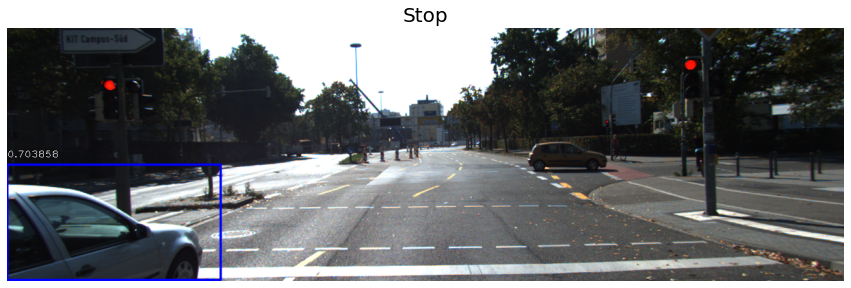

/home/aiffel0042/aiffel/object_detection/test_set/stop_4.png
[ 684.43036   79.27667 1116.6444   372.65518]


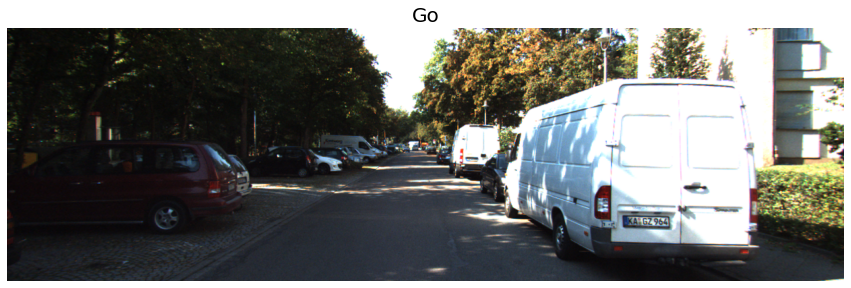

/home/aiffel0042/aiffel/object_detection/test_set/stop_5.png
[ 876.47107  170.59314 1241.0684   373.6249 ]
[ 876  170 1241  373]
[728.0113  163.28117 858.82104 245.83592]


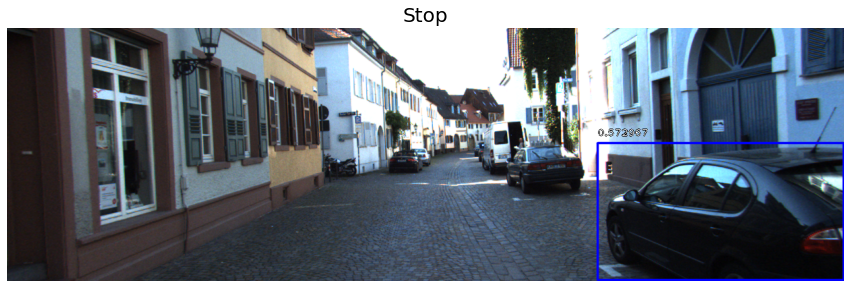

/home/aiffel0042/aiffel/object_detection/test_set/go_1.png
[593.3866  176.18837 625.1325  205.71556]
[593 176 625 205]
[192.46    133.64839 339.56473 234.19292]


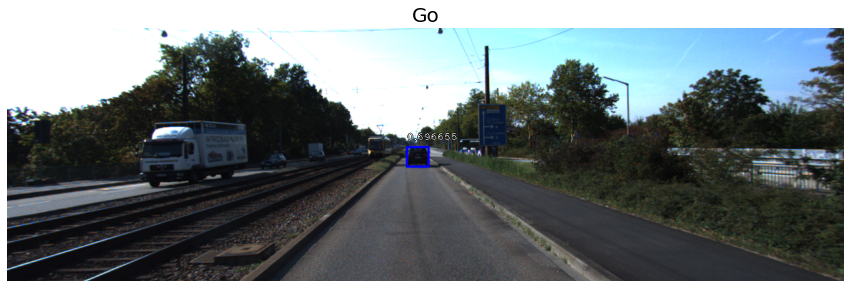

/home/aiffel0042/aiffel/object_detection/test_set/go_2.png
[626.713   175.1764  668.49567 213.01923]
[626 175 668 213]
[518.0387  178.4585  564.9107  213.55692]


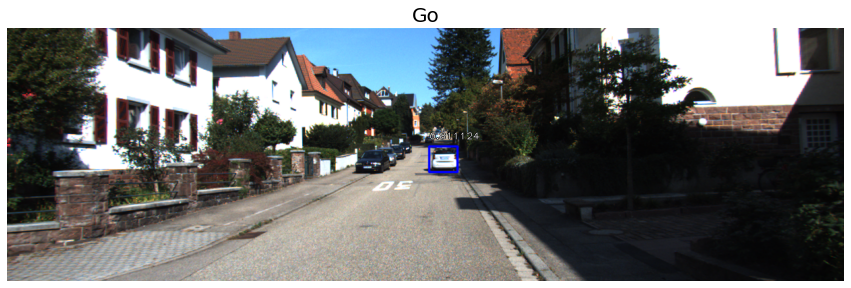

/home/aiffel0042/aiffel/object_detection/test_set/go_3.png
[808.0798  148.24997 883.4348  177.85257]


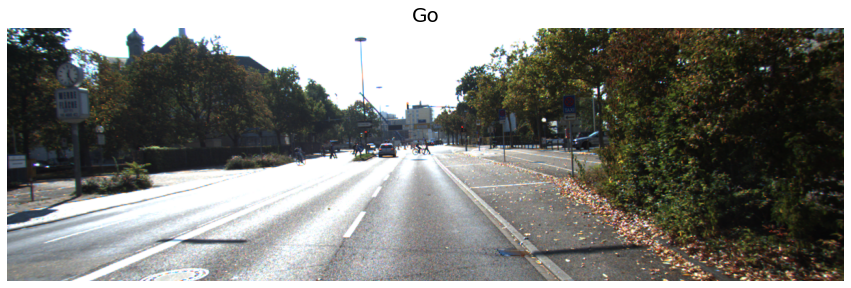

/home/aiffel0042/aiffel/object_detection/test_set/go_4.png
[693.1197  167.14377 789.93304 256.40192]


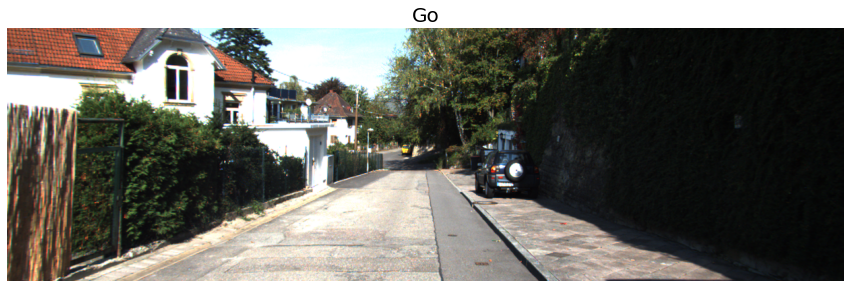

/home/aiffel0042/aiffel/object_detection/test_set/go_5.png
[ 14.414118 187.43198  204.74374  303.71194 ]


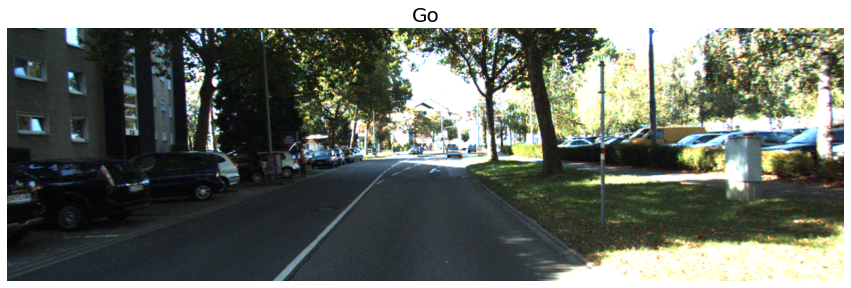

90점입니다.


In [101]:
test_system(self_drive_assist)

# 정리
---
### 1. KITTI데이터셋 분석
- [KITTI](http://www.cvlibs.net/datasets/kitti/) 데이터셋은 자율주행을 위한 데이터셋이다.
- 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공한다
    - 다음은 제공하는 라벨 정보이다
    ![image](https://user-images.githubusercontent.com/48716219/97407066-7dd8ed00-193d-11eb-9518-0d69ff24892a.png)
- 여기서는 ```tensorflow_dataset```을 활용해서 데이터를 가져온다.
    - 처음 설치할 경우 11GB가 넘어가는 대용량의 데이터셋이기 때문에 매우 오래걸린다.
- ```tensorflow_dataset```에서 ```ds_train.take(1)```데이터를 가져오고 확인해보면 xml형식(key:value)의 ```annotation``` 정보를 확인할 수 있다.
    - 다양한 ```annotation```정보 중에서 여기선 bbox에 대한 정보를 사용할 것이고 4개의 값이 담겨 있다. ( ```left```, ```top```, ```right```, ```bottom``` 의 pixel 정보)이다.

<br>  
### 2. 결과 시각화
- 다음의 두가지 조건으로 Go, Stop을 정한다.
    1. 사람이 한 명 이상 있는 경우
    2. 차량의 크기(width or height)가 300px이상인 경우
- ```model.predict_on_batch```로 학습시킨 모델을 사용해서 입력 이미지에서 detection을 수행하고 물체를 탐지하면 ```boxes```, ```scores```, ```labels```의 3가지 변수를 반환하게 된다.
    - ```self_drive_assist``` 함수 : ```result```의 default값을 ```'Go'```로 하여서 이미지에서 물체가 탐지되지 않으면 장애물이 없다는 것으로 인식하고 그대로 ```'Go'```를 반환하도록 한다.
- ```boxes``` 변수에는 총 4개의 수가 담기게 된다. 이를 활용해서 ```width```와 ```height```를 구한다.
    - ```width = boxes[2] - boxes[0]```
    - ```height = boxes[3] - boxes[1]```
- ```labels```변수에 담기는 정보 중에서 1이 담겨 있을 경우, 객체 인식에서 '사람'을 인식한 것으로 알 수 있다.

<br>  

### 3. 수행결과
- 총 10개의 사진 중에서 9개의 사진에 대해서 맞추었고 90퍼센트의 정확도를 보여주었다.